# 3. Random Forest Regressor
### Ensemble approach

- **Created by Andrés Segura Tinoco**
- **Created on Apr 15, 2022**

In [1]:
# General Libraries
import pandas as pd
import numpy as np

In [2]:
# ML Libraries - Sklearn
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [3]:
# Load Plot libraries
import matplotlib.pyplot as plt

## 3.1. Load and show data

In [4]:
# Read raw data
dataURL = "../data/dataset-single.csv"
raw_data = pd.read_csv(dataURL)

In [5]:
# Dataframe rows and columns
raw_data.shape

(2254, 16)

In [6]:
# Show default data types
raw_data.dtypes

WellID              int64
Date               object
MethodID            int64
CHP               float64
THP               float64
Temp              float64
Choke             float64
Qinj              float64
Bo                float64
Zed               float64
SpgO              float64
SpgGP             float64
Rel_Oper_Press    float64
Rel_Crit_Press    float64
WC                float64
Test_Oil          float64
dtype: object

In [7]:
# Preview the first 5 lines of the loaded data
raw_data.head()

,WellID,Date,MethodID,CHP,THP,Temp,Choke,Qinj,Bo,Zed,SpgO,SpgGP,Rel_Oper_Press,Rel_Crit_Press,WC,Test_Oil
0,84,7/23/2012,9008,305.930240,226.150470,96.87778,1.725,0.0,1.114856,0.972937,0.92303,0.799,0.739222,0.530322,0.366667,10945.72
1,84,7/24/2012,9008,306.275013,226.743155,97.46500,1.725,0.0,1.115611,0.973062,0.92303,0.799,0.740325,0.530345,0.323958,NaN
2,84,7/25/2012,9008,306.347978,227.299286,97.93182,1.725,0.0,1.116182,0.973176,0.92303,0.799,0.741964,0.530387,0.281250,NaN
3,84,7/26/2012,9008,306.309006,227.826828,99.60455,1.725,0.0,1.118186,0.973606,0.92303,0.799,0.743781,0.530576,0.325000,NaN
4,84,7/27/2012,9008,306.369882,228.283965,100.27730,1.725,0.0,1.119005,0.973771,0.92303,0.799,0.745125,0.530641,0.335000,NaN


## 3.2. Data Processing to Learn

Now the data is prepared for the learning of the Random Forest model based on the result of the Data Profiling.

In [8]:
# Create new dataframe
new_data = raw_data.copy(deep=True)

In [9]:
# List of variables to eliminate based on the Data Profiling
delete_cols = ["WellID", "SpgO", "SpgGP"]
delete_cols

['WellID', 'SpgO', 'SpgGP']

In [10]:
# Remove non-relevant columns
new_data.drop(columns=delete_cols, axis=1, inplace=True)

In [11]:
# Data quality: convert date to normalized integer
date_var = "Date"
date_fields = [date_var]

for field in date_fields:
    if field in new_data:
        row_data = pd.to_numeric(pd.to_datetime(new_data[field]))
        if field == date_var:
            date_max = row_data.max()
        new_data[field] = (row_data / row_data.max())

In [12]:
# Set deadlines values
deadline_list = ["2018-09-01", "2018-10-01"]
deadline = pd.to_numeric(pd.to_datetime(deadline_list))
date_val = deadline[0] / date_max
date_test = deadline[1] / date_max
print("Validation date:", date_val, ", Test date:", date_test)

Validation date: 0.9965799506615833 , Test date: 0.9982619421394932


#### Showing new dataframe stats

In [13]:
# Show default data types
new_data.dtypes

Date              float64
MethodID            int64
CHP               float64
THP               float64
Temp              float64
Choke             float64
Qinj              float64
Bo                float64
Zed               float64
Rel_Oper_Press    float64
Rel_Crit_Press    float64
WC                float64
Test_Oil          float64
dtype: object

In [14]:
# Preview the first 5 lines of the processed data
new_data.head()

,Date,MethodID,CHP,THP,Temp,Choke,Qinj,Bo,Zed,Rel_Oper_Press,Rel_Crit_Press,WC,Test_Oil
0,0.871496,9008,305.930240,226.150470,96.87778,1.725,0.0,1.114856,0.972937,0.739222,0.530322,0.366667,10945.72
1,0.871552,9008,306.275013,226.743155,97.46500,1.725,0.0,1.115611,0.973062,0.740325,0.530345,0.323958,NaN
2,0.871608,9008,306.347978,227.299286,97.93182,1.725,0.0,1.116182,0.973176,0.741964,0.530387,0.281250,NaN
3,0.871664,9008,306.309006,227.826828,99.60455,1.725,0.0,1.118186,0.973606,0.743781,0.530576,0.325000,NaN
4,0.871720,9008,306.369882,228.283965,100.27730,1.725,0.0,1.119005,0.973771,0.745125,0.530641,0.335000,NaN


## 3.3. Create Train/Validation/Test datasets

Now the input dataset is splitted into 3 new datasets: training (history minus 2 months), validation (last month) and testing (current month).

In [15]:
# Function that interpolates the real value (oil well test)
def get_estimated_value(kind_method=''):
    ### kind: '', cubic', 'nearest', 'previous', 'next' ###
    
    temp_data = new_data[["Test_Oil"]].dropna(thresh=1)
    x = list(temp_data.index)
    y = list(temp_data.Test_Oil)
    x_min = min(x)
    x_max = max(x)
    x_new = np.linspace(x_min, x_max, num=(x_max-x_min)+1, endpoint=True)
    
    if kind_method == '':
        f = interp1d(x, y)
    else:
        f = interp1d(x, y, kind=kind_method)
    
    y_new = f(x_new)
    return y_new

In [16]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 100 == 0:
            x_labels.append(all_labels[ix])
        else:
            x_labels.append('')
    return x_labels

In [17]:
# Find deadlines indexes
split_val = int(new_data[new_data[date_var] == date_val].index[0])
split_test = int(new_data[new_data[date_var] == date_test].index[0])
print("Split validation index:", split_val, ", split test index:", split_test)

Split validation index: 2192 , split test index: 2222


In [18]:
# Split into input (X) and output (Y) vectors
dataset = new_data.values
nCols = dataset.shape[1] - 1
x_data = dataset[:, 0:nCols]
y_data = dataset[:, nCols]
y_estimated = get_estimated_value()
xs = range(len(x_data))
xticks = get_x_labels(raw_data.Date)

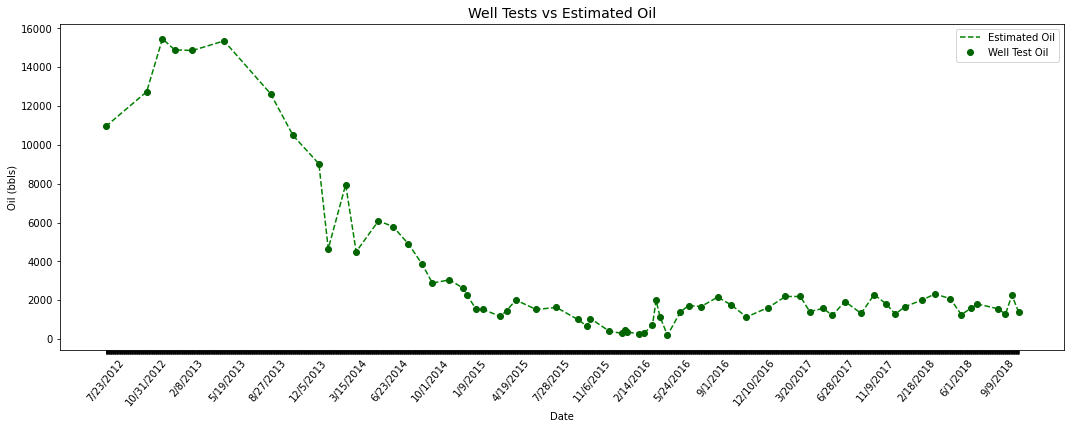

In [19]:
# Plot chart
plt.figure(figsize = (18, 6))
plt.plot(xs, y_estimated, '--', color='green')
plt.plot(xs, y_data, 'o', color='darkgreen')
plt.legend(['Estimated Oil', 'Well Test Oil'], loc='best')
plt.title('Well Tests vs Estimated Oil', fontsize = 14)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Oil (bbls)', fontsize = 10)
plt.xticks(xs, xticks, fontsize = 10, rotation = 50)
plt.show()

In [20]:
# Split into train-validation and test datasets
test_perc = (len(x_data) - split_test) / len(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_estimated, test_size=test_perc, shuffle=False)

# Split into train and validation datasets
val_perc = (len(x_train) - split_val) / len(x_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_perc, shuffle=False)
print("Train rows:", len(x_train), ", Validation rows:", len(x_val), ", Test rows:", len(x_test))

Train rows: 2192 , Validation rows: 30 , Test rows: 32


## 3.4. Train Model

<hr>
<p><a href="https://ansegura7.github.io/DataRegressors/">« Home</a></p>